In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.6/922.6 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [3]:
!pip install inference-sdk

In [34]:
analysis_results_lst = []

In [30]:
import cv2
import numpy as np
from ultralytics import YOLO
import torch
import imghdr
import os
from transformers import BlipProcessor, BlipForConditionalGeneration
from inference_sdk import InferenceHTTPClient


def generate_image_caption(image_path, detected_labels):
    """Genera una descripción de la imagen usando BLIP ligero y toma en cuenta las etiquetas detectadas."""
    processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
    model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
    from PIL import Image
    image = Image.open(image_path).convert('RGB')
    inputs = processor(image, return_tensors="pt")
    caption_ids = model.generate(**inputs, max_new_tokens=30)
    caption = processor.batch_decode(caption_ids, skip_special_tokens=True)[0]

    # Agregar etiquetas detectadas por Roboflow a la descripción
    if detected_labels:
        caption += f" (Detected elements: {', '.join(detected_labels)})"

    return caption

def detect_objects(image_path, model_path='yolov8x.pt'):
    model = YOLO(model_path)  # Usa YOLOv8 para la detección
    results = model(image_path)  # Realiza la detección
    return results

def evaluate_context(description, structured_values):
    """Genera una evaluación del contexto basada en la descripción y los valores estructurados."""
    prompt = f"""
    Analiza el siguiente contenido y proporciona una evaluación del contexto en base a la seguridad, nivel de lujo y riesgo financiero:

    Descripción de la imagen: {description}
    Valores estructurados:
    - Presencia de artículos de lujo: {structured_values['presencia_de_articulos_de_lujo']}
    - Tipo de alimentos y restaurantes: {structured_values['tipo_de_alimentos_y_restaurantes']}
    - Aparición en situaciones de riesgo (1-5): {structured_values['aparicion_en_situaciones_de_riesgo']}
    - Indicador de violencia (1-5): {structured_values['indicador_violencia']}

    Basado en estos datos, proporciona una calificación general del contexto (seguro, moderado, riesgoso) y un breve análisis del impacto en la seguridad y estabilidad financiera.
    """

    return prompt

def detect_objects_roboflow(image_path):
    """Detecta objetos usando la API de Roboflow."""
    CLIENT = InferenceHTTPClient(
        api_url="https://detect.roboflow.com",
        api_key="EICmnffK3dLzrVYGWnCN"
    )

    result = CLIENT.infer(image_path, model_id="violence-dangerous-object/3")
    detected_labels = [prediction['class'] for prediction in result['predictions'] if prediction['confidence'] > 0.5]

    return detected_labels, result['predictions']

def draw_detections(image_path, yolo_results, roboflow_results):
    """Dibuja las detecciones de YOLO y Roboflow en la imagen y las muestra."""
    image = cv2.imread(image_path)
    if image is None:
        print("Error: No se pudo cargar la imagen.")
        return

    # Dibujar detecciones de YOLO
    for result in yolo_results:
        for box in result.boxes:
            class_id = int(box.cls[0])
            conf = float(box.conf[0])
            label = result.names[class_id]
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(image, f"{label} {conf:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Dibujar detecciones de Roboflow
    for prediction in roboflow_results:
        x1, y1, x2, y2 = map(int, [prediction['x'] - prediction['width'] / 2, prediction['y'] - prediction['height'] / 2,
                                   prediction['x'] + prediction['width'] / 2, prediction['y'] + prediction['height'] / 2])
        label = prediction['class']
        conf = prediction['confidence']
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(image, f"{label} {conf:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    from google.colab.patches import cv2_imshow
    cv2_imshow(image)

def analyze_image(image_path):
    roboflow_labels, roboflow_results = detect_objects_roboflow(image_path)
    caption = generate_image_caption(image_path, roboflow_labels)
    yolo_results = detect_objects(image_path)

    detected_objects = []
    target_classes = ["laptop", "cell phone", "watch", "handbag", "sneakers", "bottle", "alcohol", "weapon", "smoke", "credit card", "luxury car", "gun", "drugs", "knife", "pistol"]

    for result in yolo_results:
        for box in result.boxes:
            class_id = int(box.cls[0])
            conf = float(box.conf[0])
            label = result.names[class_id]
            if label and conf > 0.5:
                detected_objects.append(label)

    detected_objects.extend(roboflow_labels)

    # Definir valores estructurados
    structured_values = {
        "presencia_de_articulos_de_lujo": "SI" if any(obj in ["watch", "handbag", "sneakers", "luxury car"] for obj in detected_objects) else "NO",
        "tipo_de_alimentos_y_restaurantes": "No identificado",  # No se detectan alimentos en este análisis
        "aparicion_en_situaciones_de_riesgo": max([{"pistol": 5, "knife": 4, "weapon": 4, "drugs": 5, "alcohol": 3, "smoke": 2}.get(obj, 1) for obj in detected_objects], default=1),
        "indicador_violencia": max([{"pistol": 5, "knife": 4, "weapon": 4, "smoke": 2}.get(obj, 1) for obj in detected_objects], default=1)
    }

    # Dibujar las detecciones combinadas
    draw_detections(image_path, yolo_results, roboflow_results)

    # Evaluación contextual como prompt para otro modelo de IA
    context_evaluation = evaluate_context(caption, structured_values)

    # Análisis basado en los objetos detectados
    analysis = {
        "Image Description": caption,
        "Detected Objects (YOLO & Roboflow)": detected_objects,
        "Structured Values": structured_values,
        "Context Evaluation Prompt": context_evaluation
    }

    return analysis



image 1/1 /content/danae6.png: 640x416 2 cups, 3 bowls, 1 dining table, 68.4ms
Speed: 8.3ms preprocess, 68.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 416)


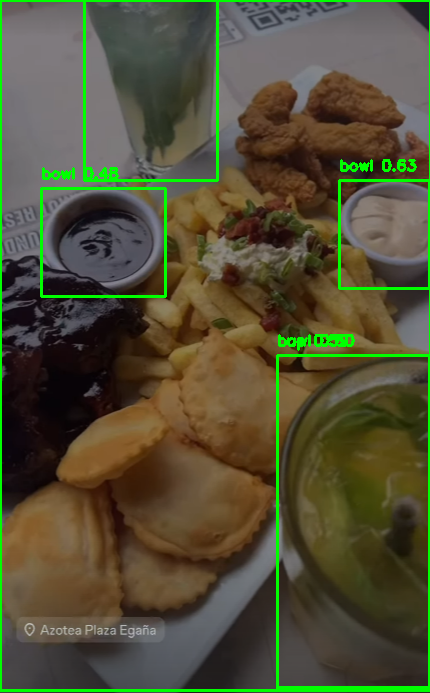

Analysis Results: {'Image Description': 'a plate of food with fries and drinks', 'Detected Objects (YOLO & Roboflow)': ['cup', 'bowl', 'bowl', 'cup', 'dining table'], 'Structured Values': {'presencia_de_articulos_de_lujo': 'NO', 'tipo_de_alimentos_y_restaurantes': 'No identificado', 'aparicion_en_situaciones_de_riesgo': 1, 'indicador_violencia': 1}, 'Context Evaluation Prompt': '\n    Analiza el siguiente contenido y proporciona una evaluación del contexto en base a la seguridad, nivel de lujo y riesgo financiero:\n\n    Descripción de la imagen: a plate of food with fries and drinks\n    Valores estructurados:\n    - Presencia de artículos de lujo: NO\n    - Tipo de alimentos y restaurantes: No identificado\n    - Aparición en situaciones de riesgo (1-5): 1\n    - Indicador de violencia (1-5): 1\n\n    Basado en estos datos, proporciona una calificación general del contexto (seguro, moderado, riesgoso) y un breve análisis del impacto en la seguridad y estabilidad financiera.\n    '}


In [48]:
# Uso
image_path = "/content/image.png"
if os.path.exists(image_path):
    analysis_results = analyze_image(image_path)
    print("Analysis Results:", analysis_results)
else:
    print("Error: La imagen no existe en el directorio actual. Sube la imagen antes de ejecutar el análisis.")

In [49]:
analysis_results_lst.append(analysis_results)

In [50]:
import pandas as pd
from IPython.display import display

# Crear el DataFrame con la nueva estructura
df_multi_analysis_updated = pd.DataFrame([
    {
        "Descripción de la Imagen": analysis["Image Description"],
        "Objetos Detectados": ", ".join(analysis["Detected Objects (YOLO & Roboflow)"]),
        "Presencia de Artículos de Lujo": analysis["Structured Values"]["presencia_de_articulos_de_lujo"],
        "Tipo de Alimentos y Restaurantes": analysis["Structured Values"]["tipo_de_alimentos_y_restaurantes"],
        "Aparición en Situaciones de Riesgo (1-5)": analysis["Structured Values"]["aparicion_en_situaciones_de_riesgo"],
        "Indicador de Violencia (1-5)": analysis["Structured Values"]["indicador_violencia"]
    }
    for analysis in analysis_results_lst
])

# Mostrar la tabla con múltiples análisis en formato estructurado
display(df_multi_analysis_updated)



,Descripción de la Imagen,Objetos Detectados,Presencia de Artículos de Lujo,Tipo de Alimentos y Restaurantes,Aparición en Situaciones de Riesgo (1-5),Indicador de Violencia (1-5)
0,a woman in a yellow top and black pants is dan...,person,NO,No identificado,1,1
1,a woman wearing a sombrel hat,"person, person",NO,No identificado,1,1
2,a woman wearing a hat and sunglasses,person,NO,No identificado,1,1
3,a group of people standing in a circle,"person, person",NO,No identificado,1,1
4,a plate of food with fries and drinks,"cup, bowl, bowl, cup, dining table",NO,No identificado,1,1


In [51]:
import pandas as pd
from IPython.display import display
import openai

# Textos que vienen del WebScrapping
textos = [
    "Parque Histórico de Guayaquil",
    "España-Barcelona",
    "Monticello-Grand Casino",
    "Hay un grupo que no me deja estar sola, ellos son una bonita casualidad",
    "Los quiero mucho!",
    "Cómo le digo a mi mamá que perdí la casa?"
]

# Variables para categorizar el análisis
categorias = [
    "Actividades",
    "Actividades",
    "Actividades",
    "Interacción Social",
    "Sentimientos",
    "Preocupaciones"
]

# Función para hacer la solicitud a OpenAI
def obtener_respuesta_openai(prompt):
    response = openai.ChatCompletion.create(
        model="gpt-4",
        messages=[{"role": "system", "content": "Analiza el siguiente texto y proporciona una evaluación breve del comportamiento asociado."},
                  {"role": "user", "content": prompt}],
        api_key=OPENAI_API_KEY
    )
    return response["choices"][0]["message"]["content"]

# Procesar cada texto y obtener respuestas
descripciones = [obtener_respuesta_openai(texto) for texto in textos]

# Crear el DataFrame con la información estructurada
df = pd.DataFrame({"Variable": categorias, "Descripción": descripciones})

# Mostrar la tabla al usuario
display(df)


,Variable,Descripción
0,Interacción Social,Mención a un grupo de personas que lo acompaña...
1,Sentimientos,Expresión de emociones relacionadas con la com...
2,Preocupaciones,Preocupación expresada abiertamente sobre cómo...
3,Actividades,Visitas a diferentes lugares: Parque Histórico...
4,Estilo de Vida,"Intereses en viajes, turismo, entretenimiento ..."
